## ËØªÂèñpackage

In [5]:
import pandas as pd
import numpy as np
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.base import BaseEstimator, ClusterMixin, clone
import pickle
import warnings
from sklearn.utils import check_random_state
from fcmeans import FCM
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score
from scipy.spatial.distance import cdist
from sklearn.metrics import normalized_mutual_info_score
from tqdm import tqdm  # Import tqdm for progress bars
from scipy.stats import sem
from scipy.stats import t
warnings.filterwarnings("ignore")
from sklearn.cluster import KMeans
np.random.seed(24)
random_state = check_random_state(24)

class FCMWrapper(BaseEstimator, ClusterMixin):
    def __init__(self, n_clusters=2, fuzziness=2.0, max_iter=1000, error=1e-5, random_state=24, init='k-means++'):
        self.n_clusters = n_clusters
        self.fuzziness = fuzziness
        self.max_iter = max_iter
        self.error = error
        self.random_state = random_state
        self.init = init
        
    def fit(self, X, y=None):
        X = X.to_numpy() if isinstance(X, pd.DataFrame) else X
        kmeans = KMeans(n_clusters=self.n_clusters, init=self.init, random_state=self.random_state)
        kmeans.fit(X)
        initial_centers = kmeans.cluster_centers_
        
        self.fcm = FCM(n_clusters=self.n_clusters, m=self.fuzziness, max_iter=self.max_iter, error=self.error, 
                       random_state=self.random_state, initial_centers=initial_centers)
        self.fcm.fit(X)
        return self
    
    def predict(self, X):
        X = X.to_numpy() if isinstance(X, pd.DataFrame) else X
        return self.fcm.predict(X)
    
    def fit_predict(self, X, y=None):
        self.fit(X)
        return self.predict(X)
    
    @property
    def u_(self):
        return self.fcm.u
    
    @property
    def centers(self):
        return self.fcm.centers
    
    def fuzzy_partition_coefficient(self):
        u = self.u_
        return np.sum(u ** 2) / u.shape[0]  # ËÆ°ÁÆó Fuzzy Partition Coefficient (FPC)


def kwons_v_k_score_func(estimator, X):
    u = estimator.u_
    centers = estimator.centers
    distances = cdist(X, centers, metric='sqeuclidean')
    score = np.sum(u * distances)
    return (1.0 / score * 100) if score != 0 else np.inf  # Èò≤Ê≠¢Èô§‰ª•Èõ∂ÔºåÂπ∂ÊîæÂ§ß 100 ÂÄç

# Custom scoring function for Fuzzy Silhouette Index
def fuzzy_silhouette_score_func(estimator, X):
    labels = estimator.predict(X)
    return silhouette_score(X, labels)

def xie_beni_score_func(estimator, X):
    estimator.fit(X)
    u = estimator.u_
    centroids = estimator.centers
    n_samples = X.shape[0]
    m = estimator.fuzziness
    distances_squared = cdist(X, centroids, metric='sqeuclidean')
    compactness = np.sum((u ** m) * distances_squared)
    centroids_dist_squared = cdist(centroids, centroids, metric='sqeuclidean')
    np.fill_diagonal(centroids_dist_squared, np.inf)
    separation = np.min(centroids_dist_squared)
    
    if separation == 0:
        return np.inf
    
    xie_beni_index = compactness / (n_samples * separation)
    
    return xie_beni_index

def objective_function(estimator, X):
    u = estimator.u_
    centers = estimator.centers
    m = estimator.fuzziness
    distances = cdist(X, centers, metric='sqeuclidean')
    return np.sum((u ** m) * distances)


In [3]:


data = pd.read_excel('/Users/zhangtongyi/Desktop/P0022024-ËÆ§Áü•ËÅöÁ±ª-project(ÊúÄÊñ∞ÁâàÔºâ/A.ÊúÄÊñ∞ÁâàÊú¨/2.‰∏ªÁªìÊûú/2.ÈáçÂ§çÈ™åËØÅ-ËÅöÁ±ªÂàÜÊûê/0.Êï∞ÊçÆÈ¢ÑÂ§ÑÁêÜ/2.Âü∫‰∫éÂØπÁÖßÁöÑ EF z-score Ê†áÂáÜÂåñÊÇ£ËÄÖÁöÑ EF ÂÄºÔºåÁÑ∂ÂêéÂü∫‰∫éÂØπÁÖßÁªÑÂæóÂà∞ÁöÑÂõûÂΩíÁ≥ªÊï∞Ê†°Ê≠£ÊÇ£ËÄÖ EF ÂÄºÁöÑ‰∫∫Âè£Â≠¶ÊïàÂ∫î /table/Ê†°Ê≠£Âπ∂Ê†áÂáÜÂåñÂêéÁöÑÊÇ£ËÄÖË°å‰∏∫ÂèòÈáèÊï∞ÊçÆ.xlsx')
EFs_data = data[['Stroop_incongruent_rt', 'Stroop_interference effect_rt', 'Nogo_acc', 'Switch_cost', 'RM-1,750_acc', 'RM-750_acc', 'DSBT_Span']]

fcm_param_grid = {
    'n_clusters': list(range(2, 8)),
    'fuzziness': np.arange(1.75, 2.55, 0.25).tolist(),
    'random_state': [2024],
    'max_iter': [1000],
    'error': [1e-5],
    'init': ['k-means++']
}

best_params_scores = {}
membership_matrices = {}
all_results = {}
best_results = {}

for n_clusters in tqdm(range(2, 8), desc="Clustering Progress"):
    print(f"ÁõÆÂâçÊ≠£Âú®ËøêË°åÁöÑËÅöÁ±ªÊï∞ÁõÆÔºö{n_clusters}")
    
    best_fuzzy_silhouette_score = -np.inf
    best_model = None
    best_fuzziness = None
    
    for fuzziness in np.arange(1.5, 2.55, 0.25):
        fcm_grid_search = GridSearchCV(FCMWrapper(n_clusters=n_clusters, fuzziness=fuzziness), 
                                       {k: v for k, v in fcm_param_grid.items() if k not in ['n_clusters', 'fuzziness']}, 
                                       cv=RepeatedKFold(n_splits=10, n_repeats=100, random_state=2024),
                                       scoring={
                                           'fuzzy_silhouette': fuzzy_silhouette_score_func,
                                           'xie_beni': xie_beni_score_func,
                                           'kwons_v_k': kwons_v_k_score_func
                                       },
                                       refit='fuzzy_silhouette', n_jobs=-1, verbose=0)

        fcm_grid_search.fit(EFs_data)
        best_model_current = fcm_grid_search.best_estimator_
        
        obj_func_values = []
        center_changes = []
        prev_centers = None
        num_iterations_to_check = 1
        count_converged = 0
        converged = False

        for iteration in range(best_model_current.max_iter):
            best_model_current.fit(EFs_data)
            obj_func_value = objective_function(best_model_current, EFs_data)
            obj_func_values.append(obj_func_value)
            
            if prev_centers is not None:
                center_change = np.sum(np.abs(best_model_current.centers - prev_centers))
                center_changes.append(center_change)
                
                if center_change < best_model_current.error:
                    count_converged += 1
                    if count_converged >= num_iterations_to_check:
                        converged = True
                else:
                    count_converged = 0
            
            prev_centers = best_model_current.centers.copy()

        if converged:
            print(f"FCM converged after {len(center_changes)} iterations for n_clusters = {n_clusters}, fuzziness = {fuzziness}")
        else:
            print(f"FCM did not converge after {best_model_current.max_iter} iterations for n_clusters = {n_clusters}, fuzziness = {fuzziness}")

        fcm_best_params = fcm_grid_search.best_params_
        fcm_best_score = fcm_grid_search.best_score_

        mean_fuzzy_silhouette_score = fcm_grid_search.cv_results_['mean_test_fuzzy_silhouette'][fcm_grid_search.best_index_]
        std_fuzzy_silhouette_score = fcm_grid_search.cv_results_['std_test_fuzzy_silhouette'][fcm_grid_search.best_index_]

        mean_xie_beni_score = fcm_grid_search.cv_results_['mean_test_xie_beni'][fcm_grid_search.best_index_]
        std_xie_beni_score = fcm_grid_search.cv_results_['std_test_xie_beni'][fcm_grid_search.best_index_]

        mean_kwons_v_k_score = fcm_grid_search.cv_results_['mean_test_kwons_v_k'][fcm_grid_search.best_index_]
        std_kwons_v_k_score = fcm_grid_search.cv_results_['std_test_kwons_v_k'][fcm_grid_search.best_index_]

        membership_matrix = fcm_grid_search.best_estimator_.u_

        membership_matrices[(n_clusters, fuzziness)] = membership_matrix

        all_results[(n_clusters, fuzziness)] = {
            'best_model': fcm_grid_search.best_estimator_,
            'best_params': fcm_best_params,
            'best_score': fcm_best_score,
            'mean_fuzzy_silhouette_score': mean_fuzzy_silhouette_score,
            'std_fuzzy_silhouette_score': std_fuzzy_silhouette_score,
            'mean_xie_beni_score': mean_xie_beni_score,
            'std_xie_beni_score': std_xie_beni_score,
            'mean_kwons_v_k_score': mean_kwons_v_k_score,
            'std_kwons_v_k_score': std_kwons_v_k_score,
            'membership_matrix': membership_matrix
        }

        if mean_fuzzy_silhouette_score > best_fuzzy_silhouette_score:
            best_fuzzy_silhouette_score = mean_fuzzy_silhouette_score
            best_model = fcm_grid_search.best_estimator_
            best_fuzziness = fuzziness

    best_results[n_clusters] = {
        'best_model': best_model,
        'best_fuzziness': best_fuzziness,
        'best_fuzzy_silhouette_score': best_fuzzy_silhouette_score,
        'best_xie_beni_score': mean_xie_beni_score,
        'best_kwons_v_k_score': mean_kwons_v_k_score
    }

    with open(f'./pkl/fcm_best_model_n_clusters_{n_clusters}.pkl', 'wb') as f:
        pickle.dump(best_model, f)


Clustering Progress:   0%|          | 0/6 [00:00<?, ?it/s]

ÁõÆÂâçÊ≠£Âú®ËøêË°åÁöÑËÅöÁ±ªÊï∞ÁõÆÔºö2
FCM converged after 999 iterations for n_clusters = 2, fuzziness = 1.5
FCM converged after 999 iterations for n_clusters = 2, fuzziness = 1.75
FCM converged after 999 iterations for n_clusters = 2, fuzziness = 2.0
FCM converged after 999 iterations for n_clusters = 2, fuzziness = 2.25


Clustering Progress:  17%|‚ñà‚ñã        | 1/6 [00:14<01:12, 14.52s/it]

FCM converged after 999 iterations for n_clusters = 2, fuzziness = 2.5
ÁõÆÂâçÊ≠£Âú®ËøêË°åÁöÑËÅöÁ±ªÊï∞ÁõÆÔºö3
FCM converged after 999 iterations for n_clusters = 3, fuzziness = 1.5
FCM converged after 999 iterations for n_clusters = 3, fuzziness = 1.75
FCM converged after 999 iterations for n_clusters = 3, fuzziness = 2.0
FCM converged after 999 iterations for n_clusters = 3, fuzziness = 2.25


Clustering Progress:  33%|‚ñà‚ñà‚ñà‚ñé      | 2/6 [00:45<01:36, 24.03s/it]

FCM converged after 999 iterations for n_clusters = 3, fuzziness = 2.5
ÁõÆÂâçÊ≠£Âú®ËøêË°åÁöÑËÅöÁ±ªÊï∞ÁõÆÔºö4
FCM converged after 999 iterations for n_clusters = 4, fuzziness = 1.5
FCM converged after 999 iterations for n_clusters = 4, fuzziness = 1.75
FCM converged after 999 iterations for n_clusters = 4, fuzziness = 2.0
FCM converged after 999 iterations for n_clusters = 4, fuzziness = 2.25


Clustering Progress:  50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 3/6 [01:26<01:35, 31.97s/it]

FCM converged after 999 iterations for n_clusters = 4, fuzziness = 2.5
ÁõÆÂâçÊ≠£Âú®ËøêË°åÁöÑËÅöÁ±ªÊï∞ÁõÆÔºö5
FCM converged after 999 iterations for n_clusters = 5, fuzziness = 1.5
FCM converged after 999 iterations for n_clusters = 5, fuzziness = 1.75
FCM converged after 999 iterations for n_clusters = 5, fuzziness = 2.0
FCM converged after 999 iterations for n_clusters = 5, fuzziness = 2.25


Clustering Progress:  67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 4/6 [01:58<01:03, 31.91s/it]

FCM converged after 999 iterations for n_clusters = 5, fuzziness = 2.5
ÁõÆÂâçÊ≠£Âú®ËøêË°åÁöÑËÅöÁ±ªÊï∞ÁõÆÔºö6
FCM converged after 999 iterations for n_clusters = 6, fuzziness = 1.5
FCM converged after 999 iterations for n_clusters = 6, fuzziness = 1.75
FCM converged after 999 iterations for n_clusters = 6, fuzziness = 2.0
FCM converged after 999 iterations for n_clusters = 6, fuzziness = 2.25


Clustering Progress:  83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 5/6 [02:44<00:37, 37.13s/it]

FCM converged after 999 iterations for n_clusters = 6, fuzziness = 2.5
ÁõÆÂâçÊ≠£Âú®ËøêË°åÁöÑËÅöÁ±ªÊï∞ÁõÆÔºö7
FCM converged after 999 iterations for n_clusters = 7, fuzziness = 1.5
FCM converged after 999 iterations for n_clusters = 7, fuzziness = 1.75
FCM converged after 999 iterations for n_clusters = 7, fuzziness = 2.0
FCM converged after 999 iterations for n_clusters = 7, fuzziness = 2.25


Clustering Progress: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 6/6 [03:58<00:00, 39.76s/it]

FCM converged after 999 iterations for n_clusters = 7, fuzziness = 2.5


In [5]:
# Clustering metrics for K = 2 cluster solutions
# Á®≥ÂÆöÊÄßÂàÜÊûê - ‰ΩøÁî® subsamplingÔºàÊó†ÊîæÂõûÊäΩÊ†∑Ôºâ
import numpy as np
import pickle
from sklearn.base import clone
from sklearn.metrics import adjusted_rand_score
from scipy.stats import sem, t

# ÂÅáËÆæ best_results, all_results, membership_matrices, fcm_param_grid, EFs_data ÈÉΩÂ∑≤ÂÆö‰πâÂπ∂ËΩΩÂÖ•

num_subsamples = 1000
subsample_size = int(0.85 * len(EFs_data))

for n_clusters, result in best_results.items():
    print(f"Performing stability analysis for n_clusters = {n_clusters}")
    best_model = result['best_model']

    stabilities = []
    fuzzy_silhouette_scores = []
    xie_beni_scores = []
    kwons_v_k_scores = []

    for i in range(num_subsamples):
        np.random.seed(42 + i)

        # Êó†ÊîæÂõûÊäΩÊ†∑ÔºàsubsamplingÔºâ
        subsample_indices = np.random.choice(len(EFs_data), subsample_size, replace=False)
        subsample_data = EFs_data.iloc[subsample_indices]

        # ÈáçÊñ∞ÊãüÂêàÊ®°ÂûãÂπ∂ËÆ°ÁÆóÊ†áÁ≠æ
        subsample_fcm = clone(best_model)
        subsample_fcm.fit(subsample_data)
        subsample_labels = np.argmax(subsample_fcm.u_, axis=1)

        # ÂéüÂßãÂÖ®Êï∞ÊçÆÊ†áÁ≠æ
        full_data_labels = np.argmax(best_model.u_, axis=1)
        subsample_full_labels = full_data_labels[subsample_indices]

        # ARI stability
        stability = adjusted_rand_score(subsample_labels, subsample_full_labels)
        stabilities.append(stability)

        # Ê®°Á≥äËΩÆÂªìÂæóÂàÜ
        fss = fuzzy_silhouette_score_func(subsample_fcm, subsample_data)
        fuzzy_silhouette_scores.append(fss)

        # Xie‚ÄìBeni ÊåáÊ†á
        xb = xie_beni_score_func(subsample_fcm, subsample_data)
        xie_beni_scores.append(xb)

        # Kwon‚Äôs V-K ÊåáÊ†á
        kvk = kwons_v_k_score_func(subsample_fcm, subsample_data)
        kwons_v_k_scores.append(kvk)

    # ËÆ°ÁÆó 95% ÁΩÆ‰ø°Âå∫Èó¥
    confidence_level = 0.95
    df = len(stabilities) - 1

    stability_mean = np.mean(stabilities)
    stability_se = sem(stabilities)
    stability_ci = t.interval(confidence_level, df, loc=stability_mean, scale=stability_se)

    fss_mean = np.mean(fuzzy_silhouette_scores)
    fss_se = sem(fuzzy_silhouette_scores)
    fss_ci = t.interval(confidence_level, df, loc=fss_mean, scale=fss_se)

    xb_mean = np.mean(xie_beni_scores)
    xb_se = sem(xie_beni_scores)
    xb_ci = t.interval(confidence_level, df, loc=xb_mean, scale=xb_se)

    kvk_mean = np.mean(kwons_v_k_scores)
    kvk_se = sem(kwons_v_k_scores)
    kvk_ci = t.interval(confidence_level, df, loc=kvk_mean, scale=kvk_se)

    # Â≠òÂÇ®ÁªìÊûúÂà∞ result
    result.update({
        'stability_sample_mean': stability_mean,
        'stability_ci_lower': stability_ci[0],
        'stability_ci_upper': stability_ci[1],
        'fss_sample_mean': fss_mean,
        'fss_ci_lower': fss_ci[0],
        'fss_ci_upper': fss_ci[1],
        'xb_sample_mean': xb_mean,
        'xb_ci_lower': xb_ci[0],
        'xb_ci_upper': xb_ci[1],
        'kvk_sample_mean': kvk_mean,
        'kvk_ci_lower': kvk_ci[0],
        'kvk_ci_upper': kvk_ci[1]
    })

    print(f"n_clusters = {n_clusters}: ARI stability mean = {stability_mean:.4f}, "
          f"CI: ({stability_ci[0]:.4f}, {stability_ci[1]:.4f})")

# ‰øùÂ≠òÊâÄÊúâÁªìÊûúÂíåÊ®°Âûã
all_results_df = pd.DataFrame.from_dict(all_results, orient='index')
all_results_df.to_excel('./table/fcm_all_results.xlsx', index_label=['n_clusters', 'fuzziness'])

best_results_df = pd.DataFrame.from_dict(best_results, orient='index')
best_results_df.to_excel('./table/fcm_best_results.xlsx', index_label='n_clusters')
best_results_df.to_pickle('./pkl/fcm_best_results_df.pkl')

with open('./pkl/fcm_best_results.pkl', 'wb') as f:
    pickle.dump(best_results, f)

with open('./pkl/fcm_membership_matrices.pkl', 'wb') as f:
    pickle.dump(membership_matrices, f)

with open('./pkl/fcm_param_grid.pkl', 'wb') as f:
    pickle.dump(fcm_param_grid, f)

EFs_data.to_pickle('./pkl/EFs_data.pkl')

print("ÊâÄÊúâÁªìÊûúÂíåÊ®°ÂûãÂùáÂ∑≤‰øùÂ≠òÂÆåÊàê„ÄÇ")


Performing stability analysis for n_clusters = 2
n_clusters = 2: ARI stability mean = 0.9957, CI: (0.9948, 0.9966)
Performing stability analysis for n_clusters = 3
n_clusters = 3: ARI stability mean = 0.9206, CI: (0.9171, 0.9241)
Performing stability analysis for n_clusters = 4
n_clusters = 4: ARI stability mean = 0.6913, CI: (0.6770, 0.7055)
Performing stability analysis for n_clusters = 5
n_clusters = 5: ARI stability mean = 0.9323, CI: (0.9281, 0.9365)
Performing stability analysis for n_clusters = 6
n_clusters = 6: ARI stability mean = 0.8675, CI: (0.8591, 0.8759)
Performing stability analysis for n_clusters = 7
n_clusters = 7: ARI stability mean = 0.7740, CI: (0.7639, 0.7841)
ÊâÄÊúâÁªìÊûúÂíåÊ®°ÂûãÂùáÂ∑≤‰øùÂ≠òÂÆåÊàê„ÄÇ


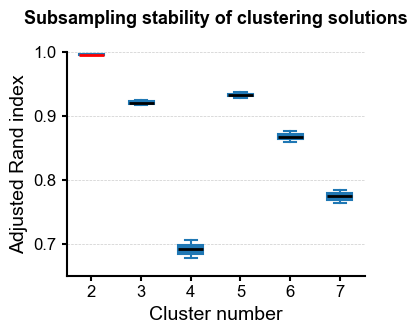

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# ËØªÂèñÊúÄ‰Ω≥ÁªìÊûúÊï∞ÊçÆ
best_results_df = pd.read_pickle('./pkl/fcm_best_results_df.pkl')

# ÊèêÂèñÁ®≥ÂÆöÊÄßÁõ∏ÂÖ≥ÁöÑÂàó
stability_cols = ['stability_sample_mean', 'stability_ci_lower', 'stability_ci_upper']
stability_data = best_results_df[stability_cols]

# ÂàõÂª∫ÂõæÂΩ¢ÂíåÂùêÊ†áËΩ¥
fig, ax = plt.subplots(figsize=(4, 3.5))

# ËÆæÁΩÆÂõæÂΩ¢Ê†∑ÂºèÔºåÂèÇËÄÉ Nature È£éÊ†º
plt.style.use('default')  # ‰ΩøÁî®ÈªòËÆ§Ê†∑Âºè
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['lines.linewidth'] = 2

# Â∞ÜÊï∞ÊçÆËΩ¨Êç¢‰∏∫Ëú°ÁÉõÂõæÈúÄË¶ÅÁöÑÊ†ºÂºè
stability_means = stability_data['stability_sample_mean'].values
stability_lowers = stability_data['stability_ci_lower'].values
stability_uppers = stability_data['stability_ci_upper'].values

# ËÆ°ÁÆóÁÆ±Á∫øÂõæÁöÑ‰∏ä‰∏ãËæπÁïåÂíåÂõõÂàÜ‰ΩçÂå∫Èó¥
box_data = [list([low, mean, upper]) for low, mean, upper in zip(stability_lowers, stability_means, stability_uppers)]

# ÁªòÂà∂ÁÆ±Á∫øÂõæÔºåË∞ÉÊï¥ÁÆ±Â≠êÁöÑÂÆΩÂ∫¶ÔºåÂπ∂Â∞ÜCluster=2ÁöÑÂùáÂÄºÁ∫øÊù°ËÆæÁΩÆ‰∏∫Á∫¢Ëâ≤
for i, (low, mean, upper) in enumerate(zip(stability_lowers, stability_means, stability_uppers), start=1):
    # ËÆæÁΩÆCluster=2ÁöÑÂùáÂÄºÁ∫øÊù°‰∏∫Á∫¢Ëâ≤
    if i == 1:  # Cluster 2
        median_color = 'red'
    else:
        median_color = 'black'
    
    ax.boxplot([[low, mean, upper]], positions=[i], patch_artist=True, showfliers=False, widths=0.5,
               boxprops=dict(facecolor='#1f77b4', color='#1f77b4', linewidth=1.5),
               whiskerprops=dict(color='#1f77b4', linewidth=1.5),
               medianprops=dict(color=median_color, linewidth=2),
               capprops=dict(color='#1f77b4', linewidth=1.5))

# ËÆæÁΩÆÂõæÂΩ¢Ê†áÈ¢òÂíåÂùêÊ†áËΩ¥Ê†áÁ≠æ
ax.set_title('Subsampling stability of clustering solutions', fontsize=13, fontweight='bold', pad=20)
ax.set_xlabel('Cluster number', fontsize=14)
ax.set_ylabel('Adjusted Rand index', fontsize=14)

# ËÆæÁΩÆxËΩ¥ÂàªÂ∫¶
ax.set_xticks(range(1, len(stability_data.index) + 1))
ax.set_xticklabels(stability_data.index, fontsize=12)

# ËÆæÁΩÆyËΩ¥ËåÉÂõ¥
ax.set_ylim(0.65, 1.0)

# Ê∑ªÂä†Ê∞¥Âπ≥ÁΩëÊ†ºÁ∫ø
ax.grid(axis='y', linestyle='--', linewidth=0.5, color='#cccccc')

# ÂéªÈô§È°∂ÈÉ®ÂíåÂè≥‰æßÁöÑËæπÊ°Ü
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Ë∞ÉÊï¥Â∏ÉÂ±Ä
plt.tight_layout()

# ‰øùÂ≠ò‰∏∫È´òÂàÜËæ®ÁéáÂõæÁâá
plt.savefig('./image/FCM-stability-Nature.jpg', dpi=1200, bbox_inches='tight', transparent=True)

plt.show()

## ËÅöÁ±ªÊ®°ÂûãÊãüÂêà

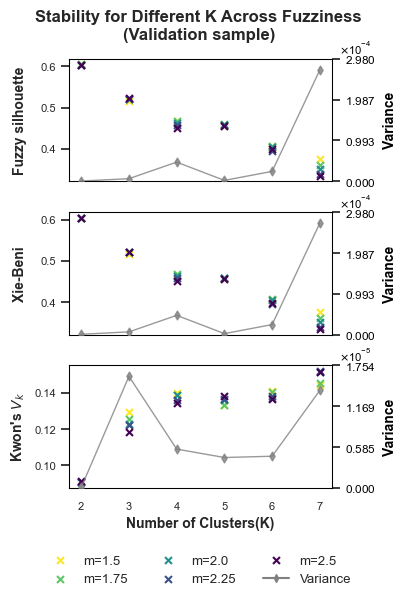

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import numpy as np

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 10

# Read data
history = pd.read_excel(
    '/Users/zhangtongyi/Desktop/P0022024-ËÆ§Áü•ËÅöÁ±ª-project(ÊúÄÊñ∞ÁâàÔºâ/A.ÊúÄÊñ∞ÁâàÊú¨/2.‰∏ªÁªìÊûú/2.ÈáçÂ§çÈ™åËØÅ-ËÅöÁ±ªÂàÜÊûê/1.FCM/2.Âü∫‰∫éÂØπÁÖßÁöÑ EF z-score Ê†áÂáÜÂåñÊÇ£ËÄÖÁöÑ EF ÂÄºÔºåÁÑ∂ÂêéÂü∫‰∫éÂØπÁÖßÁªÑÂæóÂà∞ÁöÑÂõûÂΩíÁ≥ªÊï∞Ê†°Ê≠£ÊÇ£ËÄÖ EF ÂÄºÁöÑ‰∫∫Âè£Â≠¶ÊïàÂ∫î /table/fcm_all_results.xlsx'
)

# Ëá™Âä®ÈÄâÂèñÊâÄÊúâÊï∞ÂÄºÂûãÊåáÊ†áÔºàÊéíÈô§ÂàÜÁªÑÈîÆÔºâ
numeric_cols = history.select_dtypes(include=[np.number]).columns.tolist()
metrics = [col for col in numeric_cols if col not in ['n_clusters', 'fuzziness']]

# ‚Äî‚Äî Âè™‰øùÁïôÂâç‰∏â‰∏™ÊåáÊ†á ‚Äî‚Äî 
metrics = metrics[:3]

# ÊâãÂä®ÊåáÂÆö Y ËΩ¥Ê†áÁ≠æ
metric_labels = ['Fuzzy silhouette', 'Xie-Beni', r"Kwon's $V_k$"]

# ËÆ°ÁÆóÊØè‰∏™ k ÁöÑÊñπÂ∑Æ
var_results = history.groupby('n_clusters')[metrics].var().reset_index()

# Ê†πÊçÆÊåáÊ†áÊï∞ÈáèÂàõÂª∫Â≠êÂõæÔºàÊ≠§Êó∂ num_metrics == 3Ôºâ
num_metrics = len(metrics)
fig, axs = plt.subplots(num_metrics, 1, figsize=(3.5, 5.5), sharex=True)
fig.suptitle('Stability for Different K Across Fuzziness\n(Validation sample)',
             fontsize=12, fontweight='bold', y=1.02)

# ‰∏çÂêå fuzziness ÂØπÂ∫îÁöÑÈ¢úËâ≤
fuzziness_values = sorted(history['fuzziness'].unique())
colors = plt.cm.viridis_r(np.linspace(0, 1, len(fuzziness_values)))

# Âä®ÊÄÅËÆ°ÁÆóÂêÑÊåáÊ†áÊñπÂ∑ÆËΩ¥ÁöÑËåÉÂõ¥‰∏éÂàªÂ∫¶
var_y_limits = []
var_y_ticks = []
for metric in metrics:
    y_max = var_results[metric].max() * 1.1
    var_y_limits.append((0, y_max))
    var_y_ticks.append(np.linspace(0, y_max, 4).tolist())

# ÁªòÂõæÂæ™ÁéØ
for idx, (metric, label) in enumerate(zip(metrics, metric_labels)):
    ax = axs[idx]
    ax_var = ax.twinx()

    # Â∑¶ËΩ¥ÔºöÊÄßËÉΩÊï£ÁÇπ
    for m_idx, m in enumerate(fuzziness_values):
        mask = history['fuzziness'] == m
        ax.scatter(
            history.loc[mask, 'n_clusters'],
            history.loc[mask, metric],
            label=f'm={m}',
            color=colors[m_idx],
            s=25,
            zorder=3,
            marker='x',
            alpha=1
        )

    # Âè≥ËΩ¥ÔºöÊñπÂ∑ÆÊäòÁ∫ø + Êï£ÁÇπ
    ax_var.plot(
        var_results['n_clusters'],
        var_results[metric],
        color='grey',
        linestyle='-',
        linewidth=1,
        alpha=0.8,
        label='Variance'
    )
    ax_var.scatter(
        var_results['n_clusters'],
        var_results[metric],
        color='grey',
        s=20,
        zorder=3,
        alpha=0.8,
        marker='d'
    )

    # ËΩ¥Ê†áÁ≠æ
    ax.set_ylabel(label, fontweight='bold', labelpad=5)
    ax_var.set_ylabel('Variance', fontweight='bold', labelpad=5, color='black')

    # ÂéªÈô§ÊâÄÊúâÁΩëÊ†ºÁ∫ø
    ax.grid(False)
    ax_var.grid(False)

    # ÊñπÂ∑ÆËΩ¥Ê†ºÂºèÂåñ
    ax_var.set_ylim(var_y_limits[idx])
    ax_var.set_yticks(var_y_ticks[idx])
    ax_var.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax_var.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
    ax_var.tick_params(axis='y', labelcolor='black', labelsize=8.5)
    ax_var.yaxis.offsetText.set_position((1.15, 1))
    ax_var.yaxis.offsetText.set_size(8)

    # ÂÖ¨ÂÖ±ÁöÑ x ÂàªÂ∫¶
    ax.set_xticks(sorted(history['n_clusters'].unique()))

    # Âä†Á≤óÂõõÊù°ËæπÊ°ÜÔºåÈªëËâ≤
    for spine in ax.spines.values():
        spine.set_linewidth(0.75)
        spine.set_edgecolor('black')
    for spine in ax_var.spines.values():
        spine.set_linewidth(0.75)
        spine.set_edgecolor('black')

# Â∫ïÈÉ®Â≠êÂõæÊ∑ªÂä† x ËΩ¥Ê†áÁ≠æ
axs[-1].set_xlabel('Number of Clusters(K)', fontweight='bold')

# ÊûÑÂª∫ÂêàÂπ∂Âõæ‰æã
handles, labels = axs[0].get_legend_handles_labels()
variance_handle = plt.Line2D([0], [0], color='grey', linestyle='-', marker='d', markersize=4)
handles.append(variance_handle)
labels.append('Variance')

fig.legend(
    handles, labels,
    bbox_to_anchor=(0.5, 0.05),
    loc='upper center',
    ncol=3,
    frameon=False,
    fontsize=9.5
)

# Ë∞ÉÊï¥Â∏ÉÂ±Ä
fig.align_ylabels(axs)
fig.subplots_adjust(hspace=0.25, top=0.93, bottom=0.15, left=0.13, right=0.88)

# ‰øùÂ≠òÂπ∂Â±ïÁ§∫
plt.savefig('./image/FCM_clustering_analysis.jpg', dpi=1200, bbox_inches='tight')
plt.show()

In [8]:
import pandas as pd

# Read data
history = pd.read_excel('./table/fcm_all_results.xlsx')

# Calculate variance for each k 
var_results = history.groupby('n_clusters')[metrics].var().reset_index()

print("Variance results:")
print(var_results)

Variance results:
   n_clusters  mean_fuzzy_silhouette_score  mean_xie_beni_score  \
0           2                 7.564100e-07             0.000079   
1           3                 6.487011e-06             0.000190   
2           4                 4.674436e-05             0.000985   
3           5                 2.311422e-06             0.002352   
4           6                 2.425223e-05             0.004754   
5           7                 2.709358e-04             0.002798   

   mean_kwons_v_k_score  
0              0.000026  
1              0.000355  
2              0.002129  
3              0.009944  
4              0.033632  
5              0.129887  


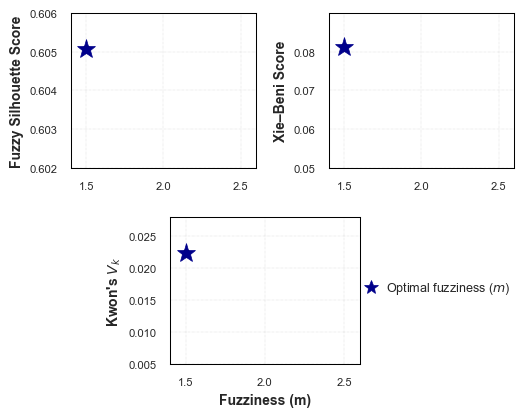

In [6]:
import warnings
from sklearn.base import InconsistentVersionWarning
warnings.filterwarnings("ignore", category=InconsistentVersionWarning)

import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

# ========== ÂÖ®Â±ÄÂèØËßÜÂåñÈ£éÊ†º & Â≠ó‰ΩìËÆæÁΩÆ ==========
# Â≠¶ÊúØËÆ∫ÊñáÂ∏∏Áî®Â≠ó‰Ωì‰∏éÁªü‰∏ÄÂ≠óÂè∑
font_family = 'Arial'
FS_LABEL = 10    # ÂùêÊ†áËΩ¥Ê†áÁ≠æÂ≠óÂè∑
FS_TICK = 8      # ÂàªÂ∫¶Ê†áÁ≠æÂ≠óÂè∑
FS_LEGEND = 9    # Âõæ‰æãÂ≠óÂè∑

sns.set(style="whitegrid")
mpl.rcParams.update({
    'font.family': font_family,
    'axes.labelsize': FS_LABEL,
    'axes.titlesize': FS_LABEL,
    'xtick.labelsize': FS_TICK,
    'ytick.labelsize': FS_TICK,
    'legend.fontsize': FS_LEGEND,
    'axes.titleweight': 'normal',
    'axes.linewidth': 1.25,
    'grid.linewidth': 0.3,
    'grid.color': 'gray',
    'grid.alpha': 0.3
})

# ========== Êï∞ÊçÆËØªÂèñ ==========
history = pd.read_excel('./table/fcm_all_results.xlsx')
best_results_df = pd.read_pickle('./pkl/fcm_best_results_df.pkl')
cluster_2_data = history[history['n_clusters'] == 2]

# ========== ÁªòÂõæÂèÇÊï∞ ==========
color = 'black'
linestyle = '-'
x_values = np.arange(1.25, 2.75, 0.25)

def mark_best_m(ax, cluster_data, metric, max_metric=True):
    idx = (cluster_data[f'mean_{metric}'].idxmax()
           if max_metric else
           cluster_data[f'mean_{metric}'].idxmin())
    m = cluster_data.loc[idx, 'fuzziness']
    score = cluster_data.loc[idx, f'mean_{metric}']
    ax.plot(m, score,
            marker='*',
            markersize=14,
            color='darkblue',
            markeredgewidth=0.5)

# ========== ÂàõÂª∫ÁîªÂ∏É ==========
fig, axes = plt.subplots(2, 2, figsize=(5.4, 4.2))

# ---------- Â≠êÂõæ1ÔºöFuzzy Silhouette Score ----------
ax1 = axes[0, 0]
ax1.plot(cluster_2_data['fuzziness'],
         cluster_2_data['mean_fuzzy_silhouette_score'],
         color=color, linestyle=linestyle, linewidth=2,
         marker='o', markersize=5)
mark_best_m(ax1, cluster_2_data, 'fuzzy_silhouette_score', max_metric=True)
ax1.set_xlim(1.4, 2.6)
ax1.set_xticks([1.5, 2.0, 2.5])
ax1.set_ylim([0.602, 0.606])
ax1.set_yticks(np.arange(0.602, 0.606, 0.001))
ax1.set_ylabel('Fuzzy Silhouette Score', fontweight='bold')
ax1.grid(which='both', axis='both', linestyle='-.')

# ---------- Â≠êÂõæ2ÔºöXie‚ÄìBeni Score ----------
ax2 = axes[0, 1]
ax2.plot(cluster_2_data['fuzziness'],
         cluster_2_data['mean_xie_beni_score'],
         color=color, linestyle=linestyle, linewidth=2,
         marker='o', markersize=5)
mark_best_m(ax2, cluster_2_data, 'xie_beni_score', max_metric=False)
ax2.set_xlim(1.4, 2.6)
ax2.set_xticks([1.5, 2.0, 2.5])
ax2.set_ylim([0.05, 0.09])
ax2.set_yticks(np.arange(0.05, 0.09, 0.01))
ax2.set_ylabel('Xie‚ÄìBeni Score', fontweight='bold')
ax2.grid(which='both', axis='both', linestyle='-.')

# ÈöêËóèÂ∫ïÈÉ®‰∏§‰∏™Á©∫ÁôΩÁîªÂ∏É
axes[1, 0].axis('off')
axes[1, 1].axis('off')

# ---------- Â≠êÂõæ3ÔºöKwon‚Äôs V‚Çñ ScoreÔºàËá™ÂÆö‰πâ‰ΩçÁΩÆÔºâ ----------
pos = axes[1, 0].get_position()
new_left = pos.x0 + pos.width * 0.58
new_bottom = pos.y0 - pos.height * 0.11
new_width = pos.width
new_height = pos.height
ax3 = fig.add_axes([new_left, new_bottom, new_width, new_height])

ax3.plot(cluster_2_data['fuzziness'],
         cluster_2_data['mean_kwons_v_k_score'],
         color=color, linestyle=linestyle, linewidth=2,
         marker='o', markersize=5)
mark_best_m(ax3, cluster_2_data, 'kwons_v_k_score', max_metric=False)
ax3.set_xlim(1.4, 2.6)
ax3.set_xticks([1.5, 2.0, 2.5])

ax3.set_ylim([0.005, 0.028])
ax3.set_yticks(np.arange(0.005, 0.028, 0.005))
ax3.set_xlabel('Fuzziness (m)', fontweight='bold')
ax3.set_ylabel("Kwon's $V_k$", fontweight='bold')
ax3.grid(which='both', axis='both', linestyle='-.')

# ========== ËÆæÁΩÆÊâÄÊúâÂ≠êÂõæÁöÑÂ§ñÊ°Ü‰∏∫ÈªëËâ≤ ==========
for ax in [ax1, ax2, ax3]:
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(0.75)

# ========== Âõæ‰æã & Â∏ÉÂ±Ä ==========
legend_line = mpl.lines.Line2D(
    [0], [0],
    color='darkblue',
    marker='*',
    linestyle='None',
    markersize=10,
    markeredgewidth=0.5,
    label='Optimal fuzziness ($m$)'
)
fig.legend(
    handles=[legend_line],
    loc='upper center',
    bbox_to_anchor=(0.82, 0.3),
    ncol=1,
    handletextpad=0.2,  
    frameon=False
)

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.savefig(
    './image/fcm_nature_style_cluster2_plot.jpg',
    dpi=1200,
    bbox_inches='tight',
    transparent=True
)
plt.show()

In [10]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ÊåáÂÆöÊ®°ÂûãË∑ØÂæÑ
model_path = '/Users/zhangtongyi/Desktop/ÊàëËÆ∫ÊñáÁöÑÊï∞ÊçÆÊñáÊ°£/P0032024-ËÆ§Áü•ËÅöÁ±ª-project(ÊúÄÊñ∞ÁâàÔºâ/1.ÂΩìÂâçÊúÄÊñ∞ÁâàÊú¨ /2.ËÅöÁ±ªÂàÜÊûê(ÈáçÂ§çÈ™åËØÅ)/1.FCM/2.Âü∫‰∫éÂØπÁÖßÁöÑ EF z-score Ê†áÂáÜÂåñÊÇ£ËÄÖÁöÑ EF ÂÄºÔºåÁÑ∂ÂêéÂü∫‰∫éÂØπÁÖßÁªÑÂæóÂà∞ÁöÑÂõûÂΩíÁ≥ªÊï∞Ê†°Ê≠£ÊÇ£ËÄÖ EF ÂÄºÁöÑ‰∫∫Âè£Â≠¶ÊïàÂ∫î /pkl/fcm_model_n_clusters_2_fuzziness_2.5.pkl'

# Âä†ËΩΩÊ®°Âûã
with open(model_path, 'rb') as f_model:
    fcm_model = pickle.load(f_model)

# 1. ÊâìÂç∞ËÅöÁ±ª‰∏≠ÂøÉÂπ∂Â≠òÂÇ®‰∏∫Excel
centers = fcm_model.centers
print("ËÅöÁ±ª‰∏≠ÂøÉÔºö")
print(centers)

# Â∞ÜËÅöÁ±ª‰∏≠ÂøÉÂ≠òÂÇ®‰∏∫ExcelÊñá‰ª∂
centers_df = pd.DataFrame(centers, columns=['Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5', 'Feature_6', 'Feature_7'])
centers_df.to_excel("./table/fcm_cluster_centers.xlsx", index=False)
print("ËÅöÁ±ª‰∏≠ÂøÉÂ∑≤Â≠òÂÇ®‰∏∫ fcm_cluster_centers.xlsx")

# 2. ÊâìÂç∞Ë∂ÖÂèÇÊï∞ÁªÑÂêà
print("\nË∂ÖÂèÇÊï∞ÁªÑÂêàÔºö")
fcm_params = {
    'n_clusters': fcm_model.n_clusters,
    'fuzziness': fcm_model.fuzziness,  # ‰øÆÊîπ‰∫ÜËøôÈáå
    'max_iter': fcm_model.max_iter,
    'error': fcm_model.error
}
for param, value in fcm_params.items():
    print(f"{param}: {value}")

# 3. ÊâìÂç∞Èö∂Â±ûÂ∫¶Áü©ÈòµÂπ∂Â≠òÂÇ®‰∏∫Excel
membership_matrix = fcm_model.fcm.u  # ‰øÆÊîπ‰∫ÜËøôÈáå,ËÆøÈóÆ fcm ÁöÑ u Â±ûÊÄß

# Create an ID column
num_participants = membership_matrix.shape[0]  # Assuming the number of participants is the number of rows in the matrix
ids = [f'{i}' for i in range(num_participants)]

# Convert the membership matrix to a DataFrame and add the ID column
membership_df = pd.DataFrame(membership_matrix, columns=[f'Subtype {i+1}' for i in range(fcm_model.n_clusters)])
membership_df.insert(0, 'ID', ids)  # Insert the ID column at the first position

# Add the 'Group' column based on the conditions
conditions = [
    (membership_df['Subtype 1'] >= 0.60),
    (membership_df['Subtype 2'] >= 0.60),
    ((membership_df['Subtype 1'] < 0.60) & (membership_df['Subtype 2'] < 0.60))
]
choices = [1, 2, 3]
membership_df['Group'] = np.select(conditions, choices)

# Save the DataFrame to an Excel file
membership_df.to_excel("./table/fcm_membership_matrix.xlsx", index=False)

print("Èö∂Â±ûÂ∫¶Áü©ÈòµÂ∑≤Â≠òÂÇ®‰∏∫ fcm_membership_matrix.xlsx")

ËÅöÁ±ª‰∏≠ÂøÉÔºö
[[-0.44511225  2.02123611 -1.21821567 -0.11950362 -1.33141593 -1.13716758
  -6.60097254]
 [-0.66815174 21.51525452 -1.25074614 -0.13397248 -1.51166523 -1.52398919
  -6.82559652]]
ËÅöÁ±ª‰∏≠ÂøÉÂ∑≤Â≠òÂÇ®‰∏∫ fcm_cluster_centers.xlsx

Ë∂ÖÂèÇÊï∞ÁªÑÂêàÔºö
n_clusters: 2
fuzziness: 2.5
max_iter: 1000
error: 1e-05
Èö∂Â±ûÂ∫¶Áü©ÈòµÂ∑≤Â≠òÂÇ®‰∏∫ fcm_membership_matrix.xlsx


In [11]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ÊåáÂÆöÊ®°ÂûãË∑ØÂæÑ
model_path = '/Users/zhangtongyi/Desktop/ÊàëËÆ∫ÊñáÁöÑÊï∞ÊçÆÊñáÊ°£/P0032024-ËÆ§Áü•ËÅöÁ±ª-project(ÊúÄÊñ∞ÁâàÔºâ/1.ÂΩìÂâçÊúÄÊñ∞ÁâàÊú¨ /2.ËÅöÁ±ªÂàÜÊûê(ÈáçÂ§çÈ™åËØÅ)/1.FCM/2.Âü∫‰∫éÂØπÁÖßÁöÑ EF z-score Ê†áÂáÜÂåñÊÇ£ËÄÖÁöÑ EF ÂÄºÔºåÁÑ∂ÂêéÂü∫‰∫éÂØπÁÖßÁªÑÂæóÂà∞ÁöÑÂõûÂΩíÁ≥ªÊï∞Ê†°Ê≠£ÊÇ£ËÄÖ EF ÂÄºÁöÑ‰∫∫Âè£Â≠¶ÊïàÂ∫î /pkl/fcm_model_n_clusters_2_fuzziness_2.0.pkl'

# Âä†ËΩΩÊ®°Âûã
with open(model_path, 'rb') as f_model:
    fcm_model = pickle.load(f_model)

# 1. ÊâìÂç∞ËÅöÁ±ª‰∏≠ÂøÉÂπ∂Â≠òÂÇ®‰∏∫Excel
centers = fcm_model.centers
print("ËÅöÁ±ª‰∏≠ÂøÉÔºö")
print(centers)

# Â∞ÜËÅöÁ±ª‰∏≠ÂøÉÂ≠òÂÇ®‰∏∫ExcelÊñá‰ª∂
centers_df = pd.DataFrame(centers, columns=['Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5', 'Feature_6', 'Feature_7'])
centers_df.to_excel("./table/fcm_cluster_centers.xlsx", index=False)
print("ËÅöÁ±ª‰∏≠ÂøÉÂ∑≤Â≠òÂÇ®‰∏∫ fcm_cluster_centers.xlsx")

# 2. ÊâìÂç∞Ë∂ÖÂèÇÊï∞ÁªÑÂêà
print("\nË∂ÖÂèÇÊï∞ÁªÑÂêàÔºö")
fcm_params = {
    'n_clusters': fcm_model.n_clusters,
    'fuzziness': fcm_model.fuzziness,  # ‰øÆÊîπ‰∫ÜËøôÈáå
    'max_iter': fcm_model.max_iter,
    'error': fcm_model.error
}
for param, value in fcm_params.items():
    print(f"{param}: {value}")

# 3. ÊâìÂç∞Èö∂Â±ûÂ∫¶Áü©ÈòµÂπ∂Â≠òÂÇ®‰∏∫Excel
membership_matrix = fcm_model.fcm.u  # ‰øÆÊîπ‰∫ÜËøôÈáå,ËÆøÈóÆ fcm ÁöÑ u Â±ûÊÄß

# Create an ID column
num_participants = membership_matrix.shape[0]  # Assuming the number of participants is the number of rows in the matrix
ids = [f'{i}' for i in range(num_participants)]

# Convert the membership matrix to a DataFrame and add the ID column
membership_df = pd.DataFrame(membership_matrix, columns=[f'Subtype {i+1}' for i in range(fcm_model.n_clusters)])
membership_df.insert(0, 'ID', ids)  # Insert the ID column at the first position

# Add the 'Group' column based on the conditions
conditions = [
    (membership_df['Subtype 1'] >= 0.60),
    (membership_df['Subtype 2'] >= 0.60),
    ((membership_df['Subtype 1'] < 0.60) & (membership_df['Subtype 2'] < 0.60))
]
choices = [1, 2, 3]
membership_df['Group'] = np.select(conditions, choices)

# Save the DataFrame to an Excel file
membership_df.to_excel("./table/fcm_membership_matrix2.0.xlsx", index=False)

print("Èö∂Â±ûÂ∫¶Áü©ÈòµÂ∑≤Â≠òÂÇ®‰∏∫ fcm_membership_matrix2.0.xlsx")

ËÅöÁ±ª‰∏≠ÂøÉÔºö
[[-0.46513264  1.88846456 -1.22610834 -0.11793779 -1.33483673 -1.12888981
  -6.591784  ]
 [-0.66220796 21.63434323 -1.24021177 -0.13272617 -1.53275352 -1.543622
  -6.84094095]]
ËÅöÁ±ª‰∏≠ÂøÉÂ∑≤Â≠òÂÇ®‰∏∫ fcm_cluster_centers.xlsx

Ë∂ÖÂèÇÊï∞ÁªÑÂêàÔºö
n_clusters: 2
fuzziness: 2.0
max_iter: 1000
error: 1e-05
Èö∂Â±ûÂ∫¶Áü©ÈòµÂ∑≤Â≠òÂÇ®‰∏∫ fcm_membership_matrix2.0.xlsx


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ËØªÂèñ‰πãÂâç‰øùÂ≠òÁöÑExcelÊñá‰ª∂
history = pd.read_excel('./table/fcm_all_results.xlsx')

# ËØªÂèñÊúÄ‰Ω≥ÁªìÊûúÊï∞ÊçÆ
best_results_df = pd.read_pickle('./pkl/fcm_best_results_df.pkl')

# Á≠õÈÄâ n_clusters = 2 Âà∞ n_clusters = 7 ÁöÑÊï∞ÊçÆ
cluster_2_data = history[history['n_clusters'] == 2]
cluster_3_data = history[history['n_clusters'] == 3]
cluster_4_data = history[history['n_clusters'] == 4]
cluster_5_data = history[history['n_clusters'] == 5]
cluster_6_data = history[history['n_clusters'] == 6]
cluster_7_data = history[history['n_clusters'] == 7]

# ËÆæÁΩÆSeabornÈ£éÊ†º, Ë∞ÉÊï¥‰∏∫ÈÄÇÂêàNatureÊúüÂàäÁöÑÈ£éÊ†º
sns.set(style="whitegrid")

# ÂÆö‰πâÈ¢úËâ≤, Á¨¨‰∏Ä‰∏™‰∏∫Á∫¢Ëâ≤, ÂÖ∂‰ªñ‰∏∫ÊµÖËâ≤
colors = ['#E15759', '#a6bddb', '#bdbdbd', '#bcbddc', '#fed976', '#7fcdbb']
linestyles = ['-', '--', '-.', ':', '-', '--']

# Ëá™ÂÆö‰πâxËΩ¥ËåÉÂõ¥ÂíåÊ≠•Èïø
x_values = np.arange(1.25, 2.75, 0.25)

# ÂàõÂª∫‰∏Ä‰∏™1x3ÁöÑÁΩëÊ†ºÂ∏ÉÂ±ÄÔºåÂ∞Ü‰∏â‰∏™ÂõæÊîæÂú®‰∏ÄË°å‰∏≠
fig, axes = plt.subplots(3, 1, figsize=(3.5,6.8))

# ÂÆö‰πâÊ†áËÆ∞ÊúÄ‰Ω≥mÂÄºÁöÑÂáΩÊï∞
def mark_best_m(ax, cluster_data, metric, color, max_metric=True):
    if max_metric:
        best_m = cluster_data.loc[cluster_data[f'mean_{metric}'].idxmax(), 'fuzziness']
        best_score = cluster_data[f'mean_{metric}'].max()
    else:
        best_m = cluster_data.loc[cluster_data[f'mean_{metric}'].idxmin(), 'fuzziness']
        best_score = cluster_data[f'mean_{metric}'].min()
    ax.plot(best_m, best_score, marker='*', markersize=12, color=color, markeredgewidth=0.5)

# ÁªòÂà∂Á¨¨‰∏Ä‰∏™ÂõæÔºöFuzzy Silhouette Score (FSS)
for i, cluster_data in enumerate([cluster_2_data, cluster_3_data, cluster_4_data, cluster_5_data, cluster_6_data, cluster_7_data]):
    alpha_value = 1.0 if i == 0 else 0.7  # Â¶ÇÊûúÊòØcluster 2, ÂàôËÆæÁΩÆalpha‰∏∫0.9, Âê¶Âàô‰∏∫0.5
    axes[0].plot(
        cluster_data['fuzziness'],
        cluster_data['mean_fuzzy_silhouette_score'],
        color=colors[i],
        linestyle=linestyles[i],
        linewidth=2,
        marker='x',
        markersize=5,
        alpha=alpha_value
    )
    mark_best_m(axes[0], cluster_data, 'fuzzy_silhouette_score', colors[i], max_metric=True)

axes[0].set_xticks(x_values)
axes[0].set_xlim([1.4, 2.6])
axes[0].set_ylabel('Fuzzy Silhouette Score', fontsize=10, fontweight='bold')
axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda val, pos: f'{val:.2f}'))  # ‰∏§‰ΩçÂ∞èÊï∞
axes[0].grid(True, which='major', axis='y', linestyle='-.', linewidth=0.3, color='gray', alpha=0.5)
axes[0].grid(True, which='major', axis='x', linestyle='-.', linewidth=0.3, color='gray', alpha=0.5)

# ÁªòÂà∂Á¨¨‰∫å‰∏™ÂõæÔºöXie-Beni Score (XB)
for i, cluster_data in enumerate([cluster_2_data, cluster_3_data, cluster_4_data, cluster_5_data, cluster_6_data, cluster_7_data]):
    alpha_value = 1.0 if i == 0 else 0.7  # Â¶ÇÊûúÊòØcluster 2, ÂàôËÆæÁΩÆalpha‰∏∫0.9, Âê¶Âàô‰∏∫0.5
    axes[1].plot(
        cluster_data['fuzziness'],
        cluster_data['mean_xie_beni_score'],
        color=colors[i],
        linestyle=linestyles[i],
        linewidth=2,
        marker='x',
        markersize=5,
        alpha=alpha_value
    )
    mark_best_m(axes[1], cluster_data, 'xie_beni_score', colors[i], max_metric=False)

axes[1].set_xticks(x_values)
axes[1].set_xlim([1.4, 2.6])
axes[1].set_ylabel('Xie-Beni Score', fontsize=10, fontweight='bold')
axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda val, pos: f'{val:.2f}'))  # ‰∏§‰ΩçÂ∞èÊï∞
axes[1].grid(True, which='major', axis='x', linestyle='-.', linewidth=0.3, color='gray', alpha=0.5)
axes[1].grid(True, which='major', axis='y', linestyle='-.', linewidth=0.3, color='gray', alpha=0.5)

# ÁªòÂà∂Á¨¨‰∏â‰∏™ÂõæÔºöKwon's V_k Score
for i, cluster_data in enumerate([cluster_2_data, cluster_3_data, cluster_4_data, cluster_5_data, cluster_6_data, cluster_7_data]):
    alpha_value = 1.0 if i == 0 else 0.7  # Â¶ÇÊûúÊòØcluster 2, ÂàôËÆæÁΩÆalpha‰∏∫0.9, Âê¶Âàô‰∏∫0.5
    axes[2].plot(
        cluster_data['fuzziness'],
        cluster_data['mean_kwons_v_k_score'],
        color=colors[i],
        linestyle=linestyles[i],
        linewidth=2,
        marker='x',
        markersize=5,
        alpha=alpha_value
    )
    mark_best_m(axes[2], cluster_data, 'kwons_v_k_score', colors[i], max_metric=False)

axes[2].set_xticks(x_values)
axes[2].set_xlim([1.4, 2.6])
axes[2].set_xlabel('Fuzziness (m)', fontsize=10, fontweight='bold')
axes[2].set_ylabel('Kwon\'s $V_k$', fontsize=10, fontweight='bold')
axes[2].yaxis.set_major_formatter(plt.FuncFormatter(lambda val, pos: f'{val:.2f}'))  # ‰∏§‰ΩçÂ∞èÊï∞
axes[2].grid(True, which='major', axis='y', linestyle='-.', linewidth=0.3, color='gray', alpha=0.5)
axes[2].grid(True, which='major', axis='x', linestyle='-.', linewidth=0.3, color='gray', alpha=0.5)

# Âà†Èô§Â≠êÂõæÊ†áÈ¢ò
for ax in axes:
    ax.set_title('')

# Ê∑ªÂä†ÊÄªÂõæ‰æã
lines = [plt.Line2D([0], [0], color=colors[i], lw=2, linestyle=linestyles[i], marker='o') for i in range(6)]
best_marker = plt.Line2D([0], [0], color='black', marker='*', linestyle='None', markersize=10, markeredgewidth=0.5, label='Best Value')

labels = ['Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7']

legend_items = lines + [best_marker]
legend_labels = labels + ['Best Value']

fig.legend(legend_items, legend_labels, loc='upper center', bbox_to_anchor=(0.55, 0.03), ncol=4, fontsize=9)

# Ê∑ªÂä†ÊÄªÊ†áÈ¢ò
fig.suptitle('Clustering Metrics Comparison\n(Recurring local validation sample', fontsize=16, fontweight='bold', y=0.94)

# Ë∞ÉÊï¥Â∏ÉÂ±Ä
plt.tight_layout(rect=[0, 0.03, 1, 0.96])  # Á°Æ‰øùÊÄªÊ†áÈ¢ò‰∏ç‰∏éÂ≠êÂõæÈáçÂè†

# ËÆæÁΩÆÊØè‰∏™Â≠êÂõæÁöÑÂ§ñËæπÊ°Ü‰∏∫ÈªëËâ≤
for ax in axes:  # Âè™ÂØπÁé∞Â≠òÁöÑ‰∏â‰∏™Â≠êÂõæËøõË°åÊìç‰Ωú
    ax.spines['top'].set_color('black')
    ax.spines['top'].set_linewidth(1.25)
    ax.spines['right'].set_color('black')
    ax.spines['right'].set_linewidth(1.25)
    ax.spines['bottom'].set_color('black')
    ax.spines['bottom'].set_linewidth(1.25)
    ax.spines['left'].set_color('black')
    ax.spines['left'].set_linewidth(1.25)

# ‰øùÂ≠òÊï¥‰∏™Âõæ‰∏∫È´òÂàÜËæ®ÁéáÂõæÁâá
plt.savefig('./image/fcm_nature_style_combined_plot_without_stability.jpg', dpi=1200, bbox_inches='tight', transparent=True)

# Â±ïÁ§∫
# Â±ïÁ§∫ÂõæÂÉè
plt.show()

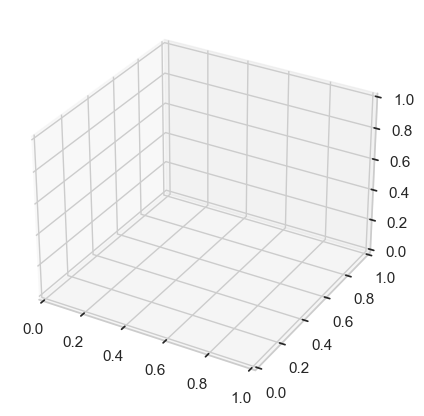

In [15]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np
import seaborn as sns
import pickle
import pandas as pd

# ËØªÂèñÊï∞ÊçÆ
data = pd.read_excel('/Users/zhangtongyi/Desktop/ÊàëËÆ∫ÊñáÁöÑÊï∞ÊçÆÊñáÊ°£/P0032024-ËÆ§Áü•ËÅöÁ±ª-project(ÊúÄÊñ∞ÁâàÔºâ/1.ÂΩìÂâçÊúÄÊñ∞ÁâàÊú¨ /2.ËÅöÁ±ªÂàÜÊûê(ÈáçÂ§çÈ™åËØÅ)/0.Êï∞ÊçÆÈ¢ÑÂ§ÑÁêÜ/2.Âü∫‰∫éÂØπÁÖßÁöÑ EF z-score Ê†áÂáÜÂåñÊÇ£ËÄÖÁöÑ EF ÂÄºÔºåÁÑ∂ÂêéÂü∫‰∫éÂØπÁÖßÁªÑÂæóÂà∞ÁöÑÂõûÂΩíÁ≥ªÊï∞Ê†°Ê≠£ÊÇ£ËÄÖ EF ÂÄºÁöÑ‰∫∫Âè£Â≠¶ÊïàÂ∫î /table/Ê†°Ê≠£Âπ∂Ê†áÂáÜÂåñÂêéÁöÑÊÇ£ËÄÖË°å‰∏∫ÂèòÈáèÊï∞ÊçÆ.xlsx')
EFs_data = data[['Stroop_incongruent_rt', 'Stroop_interference effect_rt', 'Nogo_acc', 'Switch_cost', 'RM-1,750_acc', 'RM-750_acc', 'DSBT_Span']]

# ËØªÂèñ fcm_membership_matrix.xlsx Êñá‰ª∂Âπ∂ÊèêÂèñ Group„ÄÅSubtype 1 Âíå Subtype 2 Âàó
membership_data = pd.read_excel('./table/fcm_membership_matrix.xlsx')
group_data = membership_data['Group']
subtype1_data = membership_data['Subtype 1']
subtype2_data = membership_data['Subtype 2']

# Â∞Ü Group„ÄÅSubtype 1 Âíå Subtype 2 ÂàóÊ∑ªÂä†Âà∞ÂéüÂßãÊï∞ÊçÆ‰∏≠
data['Group'] = group_data
data['Subtype 1'] = subtype1_data
data['Subtype 2'] = subtype2_data

# ‰øùÂ≠òÊõ¥Êñ∞ÂêéÁöÑÊï∞ÊçÆÂà∞Êñ∞ÁöÑ Excel Êñá‰ª∂
updated_data_path = '/Users/zhangtongyi/Desktop/ÊàëËÆ∫ÊñáÁöÑÊï∞ÊçÆÊñáÊ°£/P0032024-ËÆ§Áü•ËÅöÁ±ª-project(ÊúÄÊñ∞ÁâàÔºâ/1.ÂΩìÂâçÊúÄÊñ∞ÁâàÊú¨ /2.ËÅöÁ±ªÂàÜÊûê(ÈáçÂ§çÈ™åËØÅ)/1.FCM/2.Âü∫‰∫éÂØπÁÖßÁöÑ EF z-score Ê†áÂáÜÂåñÊÇ£ËÄÖÁöÑ EF ÂÄºÔºåÁÑ∂ÂêéÂü∫‰∫éÂØπÁÖßÁªÑÂæóÂà∞ÁöÑÂõûÂΩíÁ≥ªÊï∞Ê†°Ê≠£ÊÇ£ËÄÖ EF ÂÄºÁöÑ‰∫∫Âè£Â≠¶ÊïàÂ∫î /table/updated_data.xlsx'
data.to_excel(updated_data_path, index=False)

palette = sns.color_palette("deep", 8)

# ÂàùÂßãÂåñËØÑ‰º∞ÊåáÊ†áÂ≠óÂÖ∏
best_params_scores = {
    2: {'best_score': 0.75, 'mean_xie_beni_score': 0.12, 'mean_partition_entropy': 0.9},
    3: {'best_score': 0.72, 'mean_xie_beni_score': 0.15, 'mean_partition_entropy': 0.85},
    # Ê∑ªÂä†ÂÖ∂‰ªñ n_clusters ÁöÑËØÑ‰º∞Êï∞ÊçÆ...
}

# Ëé∑Âèñ‰∏çÂêåËÅöÁ±ªÊï∞Èáè‰∏ãÁöÑÊúÄ‰ºòÊ®°Âûã
best_models = []
for n in range(2, 8):
    with open(f'/Users/zhangtongyi/Desktop/ÊàëËÆ∫ÊñáÁöÑÊï∞ÊçÆÊñáÊ°£/P0032024-ËÆ§Áü•ËÅöÁ±ª-project(ÊúÄÊñ∞ÁâàÔºâ/1.ÂΩìÂâçÊúÄÊñ∞ÁâàÊú¨ /2.ËÅöÁ±ªÂàÜÊûê(ÈáçÂ§çÈ™åËØÅ)/1.FCM/2.Âü∫‰∫éÂØπÁÖßÁöÑ EF z-score Ê†áÂáÜÂåñÊÇ£ËÄÖÁöÑ EF ÂÄºÔºåÁÑ∂ÂêéÂü∫‰∫éÂØπÁÖßÁªÑÂæóÂà∞ÁöÑÂõûÂΩíÁ≥ªÊï∞Ê†°Ê≠£ÊÇ£ËÄÖ EF ÂÄºÁöÑ‰∫∫Âè£Â≠¶ÊïàÂ∫î /pkl/fcm_model_n_clusters_{n}_fuzziness_2.5.pkl', 'rb') as f:
        best_model = pickle.load(f)
        best_models.append(best_model)

# ËÆæÁΩÆ‰∏âÁª¥ÂõæÂΩ¢
fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111, projection='3d')

# ÈÅçÂéÜÊúÄ‰ºòÊ®°Âûã,ÊâæÂà∞ n_clusters = 2 ÁöÑÊ®°ÂûãÂπ∂ËøõË°åÂèØËßÜÂåñ
for idx, (n_clusters, model) in enumerate(zip(range(2, 8), best_models)):
    if n_clusters == 2:
        # Ëé∑ÂèñËØÑ‰º∞ÊåáÊ†á
        fuzzy_silhouette_score = best_params_scores[n_clusters]['best_score']
        xie_beni_score = best_params_scores[n_clusters]['mean_xie_beni_score']
        partition_entropy = best_params_scores[n_clusters]['mean_partition_entropy']
        
        # Ëé∑ÂèñËÅöÁ±ª‰∏≠ÂøÉÂíåÊ†áÁ≠æ
        fcm_centers = model.centers
        fcm_labels = model.predict(EFs_data)

        # ÂèØËßÜÂåñ‰ª£Á†Å‰øùÊåÅ‰∏çÂèò

        break  # Âè™ÁªòÂà∂ n_clusters = 2 ÁöÑÊ®°Âûã,ÁªòÂà∂ÂÆåÊàêÂêéÈÄÄÂá∫Âæ™ÁéØ


## ÂÖ®ÈÉ®ÂÆåÊàê

In [29]:
print("Êï∞ÊçÆÂàÜÊûêÂÖ®ÈÉ®ÂÆåÊàêÔºÅüòÇ")

Êï∞ÊçÆÂàÜÊûêÂÖ®ÈÉ®ÂÆåÊàêÔºÅüòÇ
